<a href="https://colab.research.google.com/github/sanazy/Persian-Car-Licence-Plate-Detection-and-Recognition/blob/main/OCR_using_yolov7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
PATH = '/content/gdrive/MyDrive/DPA/'

images_path = PATH + "my_images/"
save_path = PATH + "my_output/"
weights_path = PATH + "my_weights/"
lpd_weight = weights_path + "best.pt"
lpr_weight = weights_path + "best_ocr.pt"

In [3]:
%cd {PATH}/yolov7

/content/gdrive/MyDrive/DPA/yolov7


# Import Packages

In [4]:
import os
import cv2
import torch
import torch.backends.cudnn as cudnn
from numpy import random
import numpy as np
import pandas as pd
from copy import deepcopy

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages, letterbox
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel

from google.colab.patches import cv2_imshow

# License Plate Detection


In [5]:
image_size = 640

# Initialize
device = select_device('cpu')

# Load model
lpd_model = attempt_load(lpd_weight, map_location=device)  # load FP32 model
stride = int(lpd_model.stride.max())  # model stride
imgsz = check_img_size(image_size, s=stride)  # check img_size

lpd_model = TracedModel(lpd_model, device, image_size)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 



In [6]:
def detect_plate(source_image):
  # Padded resize
  img_size = 640
  stride = 32
  img = letterbox(source_image, img_size, stride=stride)[0]

  # Convert
  img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
  img = np.ascontiguousarray(img)
  img = torch.from_numpy(img).to(device)
  img = img.float()  # uint8 to fp16/32
  img /= 255.0  # 0 - 255 to 0.0 - 1.0
  if img.ndimension() == 3:
    img = img.unsqueeze(0)
      
  with torch.no_grad():
    # Inference
    pred = lpd_model(img, augment=True)[0]

  # Apply NMS
  pred = non_max_suppression(pred, 0.25, 0.45, classes=0, agnostic=True)

  plate_detections = []
  det_confidences = []
  
  # Process detections
  for i, det in enumerate(pred):  # detections per image
    if len(det):
      # Rescale boxes from img_size to im0 size
      det[:, :4] = scale_coords(img.shape[2:], det[:, :4], source_image.shape).round()

      # Return results
      for *xyxy, conf, cls in reversed(det):
        coords = [int(position) for position in (torch.tensor(xyxy).view(1, 4)).tolist()[0]]
        plate_detections.append(coords)
        det_confidences.append(conf.item())

  return plate_detections, det_confidences

# License Plate Recognition

In [7]:
# Initialize
set_logging()
device = select_device('cpu')
img_size = imgsz = 640

# Load model
lpr_model = attempt_load(lpr_weight, map_location=device)  # load FP32 model
stride = int(lpr_model.stride.max())  # model stride
imgsz = check_img_size(imgsz, s=stride)  # check img_size

lpr_model = TracedModel(lpr_model, device, img_size)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 



In [8]:
def recognize_plate(source, conf=0.3):

  # Set Dataloader
  dataset = LoadImages(source, img_size=imgsz, stride=stride)

  # Get names and colors
  names = lpr_model.module.names if hasattr(lpr_model, 'module') else lpr_model.names
  colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]

  old_img_w = old_img_h = imgsz
  old_img_b = 1

  for path, img, im0s, vid_cap in dataset:
    img = torch.from_numpy(img).to(device)
    img = img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
      img = img.unsqueeze(0)

    # Warmup
    if device.type != 'cpu' and (old_img_b != img.shape[0] or old_img_h != img.shape[2] or old_img_w != img.shape[3]):
      old_img_b = img.shape[0]
      old_img_h = img.shape[2]
      old_img_w = img.shape[3]
      for i in range(3):
        lpr_model(img, augment=True)[0]

    # Inference
    pred = lpr_model(img, augment=True)[0]

    # Apply NMS
    pred = non_max_suppression(pred, conf)

    lines = []
    # Process detections
    for i, det in enumerate(pred):  # detections per image

      _, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)
      gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
      
      if len(det):
        # Rescale boxes from img_size to im0 size
        det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

        # Print results
        for c in det[:, -1].unique():
          n = (det[:, -1] == c).sum()  # detections per class
          s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

        # Write results
        for *xyxy, conf, cls in reversed(det):
          xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
          line = (int(cls.numpy()), *xywh)  # label format
          lines.append(line)

          label = f'{names[int(cls)]}'
          plot_one_box(xyxy, im0, label=label, color=colors[int(cls)], line_thickness=1)

      # show results (image with detections)
      resized_img = cv2.resize(im0, (200, 50), interpolation = cv2.INTER_AREA)
      print("Annotated plate:")
      cv2_imshow(resized_img)

  return lines

In [9]:
def crop(image, coord):
  cropped_image = image[int(coord[1]):int(coord[3]), int(coord[0]):int(coord[2])]
  return cropped_image

In [10]:
def extract_number_plate(rects):  
  chars = {0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 
          6: "6", 7: "7", 8: "8", 9: "9", 10: "B", 11: "D", 
          12: "Gh", 13: "H", 14: "J", 15: "L", 16: "M", 17: "N", 
          18: "Sad", 19: "Sin", 20: "T", 21: "V", 22: "Y"}

  df = pd.DataFrame(rects)
  df.columns = ["label", "xmin", "ymin", "xmax", "ymax"]
  df = df.sort_values("xmin")

  number_plate = ""
  for k in df["label"]:
    number_plate += chars[k]

  return number_plate

# Pipeline LPD + LPR

Orignial image:


/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


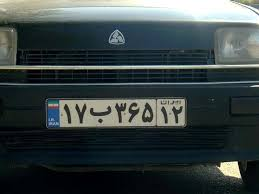

Detected plate region:


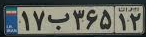

Annotated plate:


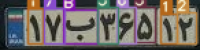

Number plate is:  17B36512


In [11]:
image_name = "image_4.jpeg"
image_path = images_path + image_name
plate_path = save_path + "ocr_" + image_name


# detect the location and confidence level of plates in image
image = cv2.imread(image_path)
plate_detections, _ = detect_plate(image)
copy_input = deepcopy(image)

print("Orignial image:")
cv2_imshow(copy_input)

# for each detected plate
for i, coords in enumerate(plate_detections):
  
  # crop the plate from original image
  plate_region = crop(copy_input, coords)
  print("Detected plate region:")
  cv2_imshow(plate_region)

  cv2.imwrite(plate_path, plate_region)

  with torch.no_grad():
    rects = recognize_plate(plate_path, conf=0.4)
    number_plate = extract_number_plate(rects)
    print("Number plate is: ", number_plate)